<a href="https://colab.research.google.com/github/zelaneroz/cwru-csds-coursework/blob/main/csds133_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohithsairamreddy/salary-data")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/mohithsairamreddy/salary-data/versions/4


In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

In [3]:
files = os.listdir(path)
csv_file = [f for f in files if f.endswith('.csv')][0]  # Finds the first CSV file
csv_path = os.path.join(path, csv_file)
df = pd.read_csv(csv_path)

# I. Initial Exploration & Data Preprocessing

## A. Initial Exploration

Using the code below, we gathered the following information:


*   6704 rows, 6 columns
*   Columns: \[Age, Gender Education, Level, Job Title, Years of Experience]
* 2 rows are empty
* Found the number of missing values per column
* Summary Statistis for each column
* Unique Values for Columns 'Education' and 'Job Title'


In [4]:
# Load dataset (update with actual file path)
# 1️⃣ Check the first few rows
print("📌 First 5 Rows:")
print(df.head(), "\n")

# 2️⃣ Check the number of rows and columns
print("📌 Shape of the dataset (rows, columns):", df.shape, "\n")

# 3️⃣ Get column names
print("📌 Column Names:")
print(df.columns, "\n")

# 4️⃣ Get basic info about dataset (data types, non-null counts, memory usage)
print("📌 Dataset Information:")
print(df.info(), "\n")

📌 First 5 Rows:
    Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0   

📌 Shape of the dataset (rows, columns): (6704, 6) 

📌 Column Names:
Index(['Age', 'Gender', 'Education Level', 'Job Title', 'Years of Experience',
       'Salary'],
      dtype='object') 

📌 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  670

In [5]:
# 5️⃣ Check for missing values
print("📌 Missing Values Per Column:")
print(df.isnull().sum(), "\n")

# 6️⃣ Count completely empty rows
print("📌 Number of Fully Empty Rows:", df.isnull().all(axis=1).sum(), "\n")

# 7️⃣ Summary statistics for numerical columns
print("📌 Summary Statistics for Numerical Columns:")
print(df.describe(), "\n")

# 8️⃣ Summary statistics for categorical columns
print("📌 Summary Statistics for Categorical Columns:")
print(df.describe(include=['object']), "\n")

# 9️⃣ Check unique values in categorical columns (adjust column names as needed)
categorical_cols = ['Gender', 'Education Level', 'Job Title']  # Adjust these column names as necessary
for col in categorical_cols:
    if col in df.columns:
        print(f"📌 Unique values in '{col}':")
        print(df[col].value_counts(), "\n")

📌 Missing Values Per Column:
Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64 

📌 Number of Fully Empty Rows: 2 

📌 Summary Statistics for Numerical Columns:
               Age  Years of Experience         Salary
count  6702.000000          6701.000000    6699.000000
mean     33.620859             8.094687  115326.964771
std       7.614633             6.059003   52786.183911
min      21.000000             0.000000     350.000000
25%      28.000000             3.000000   70000.000000
50%      32.000000             7.000000  115000.000000
75%      38.000000            12.000000  160000.000000
max      62.000000            34.000000  250000.000000 

📌 Summary Statistics for Categorical Columns:
       Gender    Education Level          Job Title
count    6702               6701               6702
unique      3                  7                193
top      Male  Bachelor's Deg

## B. Data Cleaning

From the information gathered from data exploration, we perform the following to clean the data:

*   Remove rows where all columns are empty.
*   Removes rows where at least one column has missing data.
*   Reset the index to maintain a clean dataset.


In [6]:
print("Original Dataset Shape:", df.shape)
# Drop fully empty rows (where all columns are NaN)
df = df.dropna(how='all')

# Drop rows where at least one column has missing values
df = df.dropna(how='any')

# Reset index after dropping rows
df = df.reset_index(drop=True)

# Display new shape of the dataset
print("Updated Dataset Shape:", df.shape)


Original Dataset Shape: (6704, 6)
Updated Dataset Shape: (6698, 6)


## C. Data Standardization

**Standardize Gender Column & Convert to Numeric**

In [7]:
# Convert to lowercase, strip spaces, and map to standardized values
gender_map = {
    'male': 'Male', 'm': 'Male', 'man': 'Male', 'boy': 'Male',
    'female': 'Female', 'f': 'Female', 'woman': 'Female', 'girl': 'Female'
}

df['Gender'] = df['Gender'].str.strip().str.lower().map(gender_map)

# Remove rows with invalid or missing gender values
df = df[df['Gender'].isin(['Male', 'Female'])]

# Convert Gender to Numeric (Male = 1, Female = 0)
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# Confirm changes
print("✅ Gender column standardized and converted to numeric.")
print(df['Gender'].value_counts())


✅ Gender column standardized and converted to numeric.
Gender
1    3671
0    3013
Name: count, dtype: int64


**Convert Columns to Numeric**

In [8]:
df['Years of Experience'] = pd.to_numeric(df['Years of Experience'], errors='coerce')
df['Salary'] = pd.to_numeric(df['Salary'], errors='coerce')

**Handle Salary Outliers**

In [9]:
# Remove outliers using **IQR filtering**
Q1 = df['Salary'].quantile(0.25)
Q3 = df['Salary'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Salary'] >= Q1 - 1.5 * IQR) & (df['Salary'] <= Q3 + 1.5 * IQR)]

In [10]:
# Store original number of rows before filtering
original_rows = df.shape[0]

# Compute IQR
Q1 = df['Salary'].quantile(0.25)
Q3 = df['Salary'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers before removing them
outliers = df[(df['Salary'] < Q1 - 1.5 * IQR) | (df['Salary'] > Q3 + 1.5 * IQR)]

# Remove outliers
df_cleaned = df[(df['Salary'] >= Q1 - 1.5 * IQR) & (df['Salary'] <= Q3 + 1.5 * IQR)]

# Store new number of rows after filtering
new_rows = df_cleaned.shape[0]

# Print summary of changes
print(f"✅ Original dataset had {original_rows} rows.")
print(f"✅ After IQR filtering, {new_rows} rows remain.")
print(f"🚨 {original_rows - new_rows} outliers were removed.")

# Print removed outlier rows (if any)
if not outliers.empty:
    print("\n📌 Removed Outliers (Salary Outliers Detected):")
    print(outliers)
else:
    print("\n✅ No outliers detected based on IQR filtering.")

# Save cleaned dataset
df_cleaned.to_csv("cleaned_dataset.csv", index=False)


✅ Original dataset had 6684 rows.
✅ After IQR filtering, 6684 rows remain.
🚨 0 outliers were removed.

✅ No outliers detected based on IQR filtering.


In [11]:
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,1,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,0,Master's,Data Analyst,3.0,65000.0
2,45.0,1,PhD,Senior Manager,15.0,150000.0
3,36.0,0,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,1,Master's,Director,20.0,200000.0


# II. Exploratory Data Analysis (EDA)

## A. Categorical Variables Distribution


*   Distribution of Gender
*   Distribution of Education Level
*   Distribution of Job Titles


We realized it is difficult to look into the disparities given the 193 different job titles. From this we realized we could have the following options:
*   Just look into the disparities among the top 5 jobs (based on distribution)
*   Categorize the given 193 unique job titles into industry categories (ex. finance, management, tech, etc) and conduct the comparison within these industry categories





<ipython-input-12-7a5b3c761281>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="pastel")


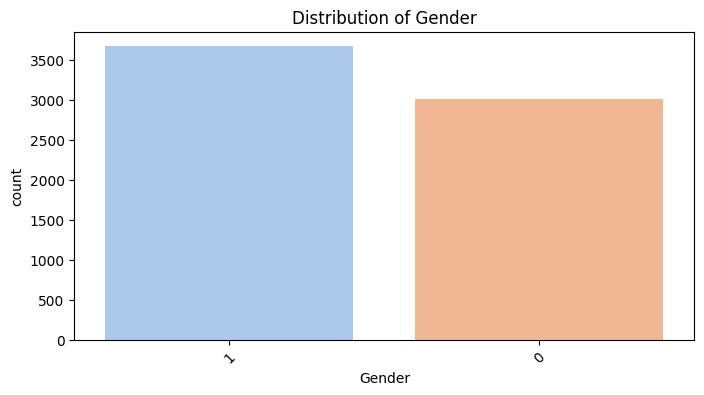

<ipython-input-12-7a5b3c761281>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="pastel")


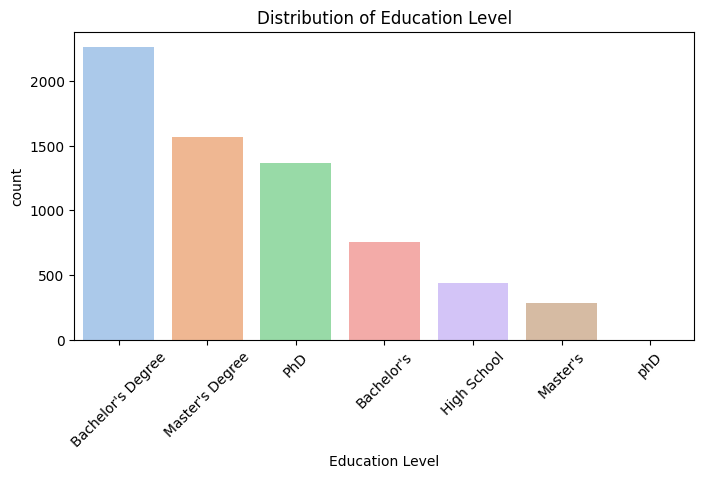

<ipython-input-12-7a5b3c761281>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], order=df[col].value_counts().index, palette="pastel")


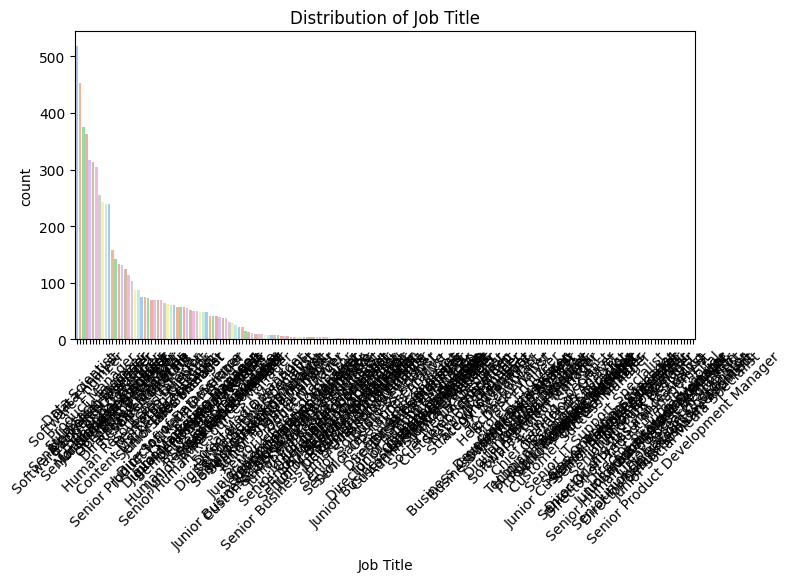

In [12]:
categorical_cols = ['Gender', 'Education Level', 'Job Title']

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[col], order=df[col].value_counts().index, palette="pastel")
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

## B. Distribution of Numerical Features

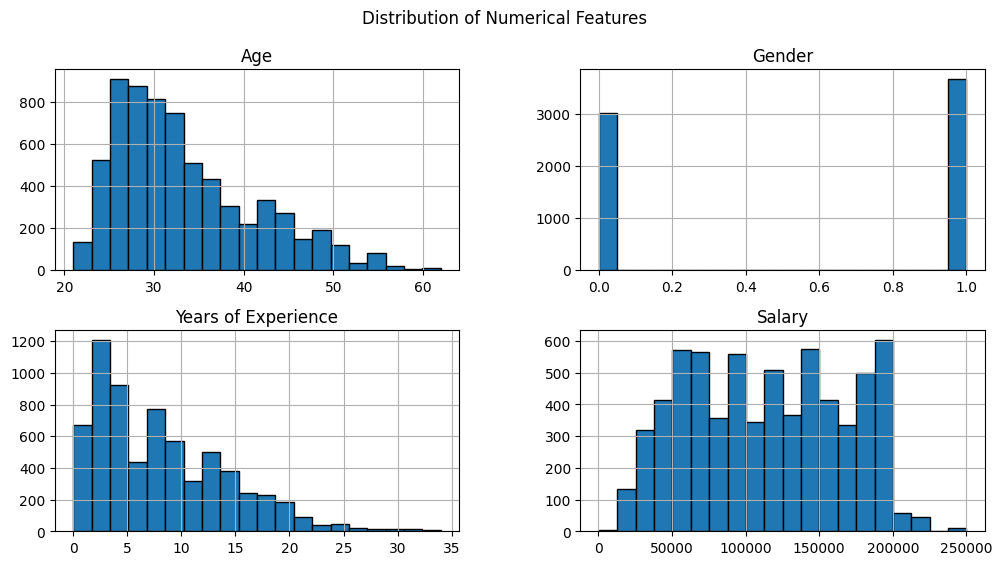

In [13]:
df.hist(figsize=(12, 6), bins=20, edgecolor="black")
plt.suptitle("Distribution of Numerical Features")
plt.show()

## C. Correlation Between Features

We wanted to create a heatmap with the education level included so we figured for this part, we figured to convert this categorical variable to numeric

In [16]:
# Define mapping for Education Level
education_map = {
    "High School": 0,
    "Bachelor's": 1,
    "Master's": 2,
    "PhD": 3
}

# Create a new numeric column in df
df['Education_Level_Num'] = df['Education Level'].map(education_map)

# Confirm changes
print("✅ Numeric Education Level added to df.")
print(df[['Education Level', 'Education_Level_Num']].head())

✅ Numeric Education Level added to df.
  Education Level  Education_Level_Num
0      Bachelor's                  1.0
1        Master's                  2.0
2             PhD                  3.0
3      Bachelor's                  1.0
4        Master's                  2.0


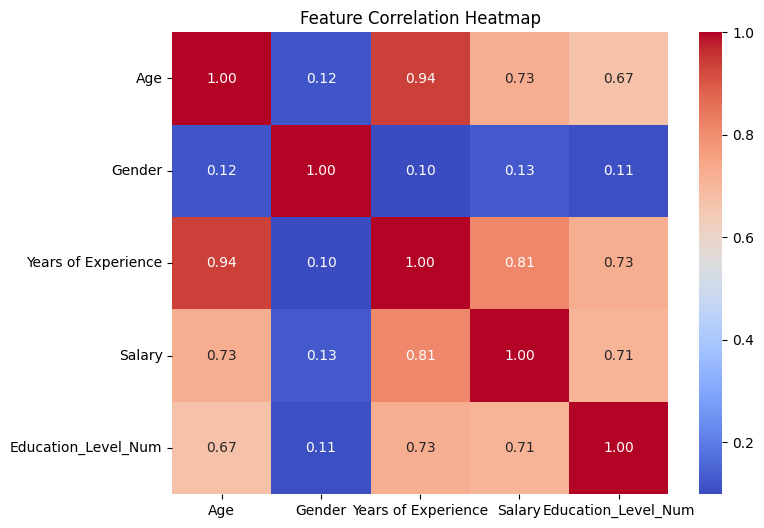

In [18]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()
